In [ ]:
# Relevant Packages
import pandas as pd
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Data Reading and Cleaning

# File
file_path = '/content/drive/MyDrive/602/finefoods_training.txt'

# Lists to store data
product_ids, user_ids, profile_names, helpfulness, scores, times, summaries, texts = [], [], [], [], [], [], [], []

# Read file
with open(file_path, 'r', encoding='ISO-8859-1') as file:
    lines = file.readlines()

# Process lines and extract data
current_review = {}
for line in lines:
    line = line.strip()
    if not line:
        continue


    if ': ' in line:
        key, value = line.split(': ', 1)
        if key.startswith('review/'):
            current_review[key.split('/')[1]] = value
        elif key.startswith('product/'):

            if current_review:
                product_ids.append(current_review.get('productId', ''))
                user_ids.append(current_review.get('userId', ''))
                profile_names.append(current_review.get('profileName', ''))
                helpfulness.append(current_review.get('helpfulness', ''))
                scores.append(current_review.get('score', ''))
                times.append(current_review.get('time', ''))
                summaries.append(current_review.get('summary', ''))
                texts.append(current_review.get('text', ''))
                current_review = {}

# Data Frame
df = pd.DataFrame({
    'product/productId': product_ids,
    'review/userId': user_ids,
    'review/profileName': profile_names,
    'review/helpfulness': helpfulness,
    'review/score': scores,
    'review/time': times,
    'review/summary': summaries,
    'review/text': texts,
})


In [ ]:
df

product/productId   review/userId               review/profileName  \
0                       A3SGXH7AUHU8GW                       delmartian   
1                       A1D87F6ZCVE5NK                           dll pa   
2                        ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3                       A395BORC6FGVXV                             Karl   
4                       A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...                ...             ...                              ...   
1994                    A172XQT2V9YUOR                       W. Simpson   
1995                    A3IJNH61DY5N9K                     Sharon Allan   
1996                    A35W3JQYP0M655          Ambergris "John Thomas"   
1997                    A3CLWZGMC7M9Z1        Hippie2MARS "Hippie2MARS"   
1998                    A2V6P1FKRHCVQQ                       S. Jackson   

     review/helpfulness review/score review/time  \
0                   1/1          5.0  1303862400   
1                   0/0          1.0  1346976000   
2                   1/1          4.0  1219017600   
3                   3/3          2.0  1307923200   
4                   0/0          5.0  1350777600   
...                 ...          ...         ...   
1994                8/8          4.0  1202601600   
1995              10/11          5.0  1265846400   
1996                7/7          5.0  1279929600   
1997                6/6          4.0  1250640000   
1998                8/9          4.0  1265760000   

                      review/summary  \
0              Good Quality Dog Food   
1                  Not as Advertised   
2              "Delight" says it all   
3                     Cough Medicine   
4                        Great taffy   
...                              ...   
1994           Delicious but pricey.   
1995  Great Waffles for us non-cooks   
1996  Excellent Fluffy Pancakes.....   
1997                  Good Basic Mix   
1998     Good pancakes, lots of work   

                                            review/text  
0     I have bought several of the Vitality canned d...  
1     Product arrived labeled as Jumbo Salted Peanut...  
2     This is a confection that has been around a fe...  
3     If you are looking for the secret ingredient i...  
4     Great taffy at a great price.  There was a wid...  
...                                                 ...  
1994  This is a delicious recipe and ingredients and...  
1995  I have to laugh at the reviews that said it wa...  
1996  I had read some favorable reviews of this panc...  
1997  I was expecting great things based on the revi...  
1998  I love this pancake mix.  I bought my first ca...  

[1999 rows x 8 columns]

For the cleaning process, I read in the file. I chose encoding='ISO-8859-1' because I was having issues reading the file without it. I created lists to hold extracted data and wrote a function that processed the file line by line determing where the extracted data would go by recognizing 'review/' or 'product/'. Each line is extracted as a dictionary and then added to the appropriate list. I then create a dataframe using those lists.

In [ ]:
# Processing Text Data
def preprocess_text(df, columns=['review/summary', 'review/text']):
    nlp = spacy.load("en_core_web_sm")

    # Convert to lowercase
    df[columns] = df[columns].apply(lambda col: col.str.lower())

    # Remove punctuation
    df[columns] = df[columns].apply(lambda col: col.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)) if pd.notna(x) else x))
    # Apply spaCy lemmatization
    df[columns] = df[columns].apply(lambda col: col.apply(lambda x: " ".join([token.lemma_ for token in nlp(x)]) if pd.notna(x) else x))
    # Convert lists to strings after lemmatization
    df[columns] = df[columns].apply(lambda col: col.apply(lambda x: " ".join(x) if isinstance(x, list) else x))



    return df

processed_df = preprocess_text(df)

I attempted to clean the review/summary and review/text columns while utilizing spaCy's package. I created a function called preprocess_text to perform the cleaning operations I desired. After getting all the text into the same format, I applied spaCy's lemmatization to break down the words into their most basic format.

In [ ]:
# New Data Frame
processed_df

product/productId   review/userId               review/profileName  \
0                       A3SGXH7AUHU8GW                       delmartian   
1                       A1D87F6ZCVE5NK                           dll pa   
2                        ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3                       A395BORC6FGVXV                             Karl   
4                       A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...                ...             ...                              ...   
1994                    A172XQT2V9YUOR                       W. Simpson   
1995                    A3IJNH61DY5N9K                     Sharon Allan   
1996                    A35W3JQYP0M655          Ambergris "John Thomas"   
1997                    A3CLWZGMC7M9Z1        Hippie2MARS "Hippie2MARS"   
1998                    A2V6P1FKRHCVQQ                       S. Jackson   

     review/helpfulness review/score review/time               review/summary  \
0                   1/1          5.0  1303862400        good quality dog food   
1                   0/0          1.0  1346976000             not as advertise   
2                   1/1          4.0  1219017600           delight say it all   
3                   3/3          2.0  1307923200               cough medicine   
4                   0/0          5.0  1350777600                  great taffy   
...                 ...          ...         ...                          ...   
1994                8/8          4.0  1202601600         delicious but pricey   
1995              10/11          5.0  1265846400  great waffle for us noncook   
1996                7/7          5.0  1279929600     excellent fluffy pancake   
1997                6/6          4.0  1250640000               good basic mix   
1998                8/9          4.0  1265760000     good pancake lot of work   

                                            review/text  
0     I have buy several of the vitality can dog foo...  
1     product arrive label as jumbo salt peanutsthe ...  
2     this be a confection that have be around a few...  
3     if you be look for the secret ingredient in ro...  
4     great taffy at a great price   there be a wide...  
...                                                 ...  
1994  this be a delicious recipe and ingredient and ...  
1995  I have to laugh at the review that say it be t...  
1996  I have read some favorable review of this panc...  
1997  I be expect great thing base on the review whi...  
1998  I love this pancake mix   I buy my first can f...  

[1999 rows x 8 columns]

In [ ]:
processed_df['combined_text'] = processed_df['review/summary'] + ' ' + processed_df['review/text']

I created a new column, 'combined_text', that merges review/summary and review/text together for later use.

In [ ]:
# Download the VADER

nltk.download('vader_lexicon')

# Create a SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(row):
    # Get sentiment scores
    scores = sid.polarity_scores(row['combined_text'])

    # Classify as positive, negative, or neutral based on the compound score
    if scores['compound'] >= 0.05:
        sentiment = 'Positive'
    elif scores['compound'] <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    return sentiment, scores['compound']

# Add sentiment and scores to the data frame
processed_df[['vader_sentiment', 'vader_compound_score']] = processed_df.apply(analyze_sentiment_vader, axis=1, result_type='expand')



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


I attempted to use the nltk package for sentiment analysis. I downloaded the vader lexicon library for use in determining the sentiment of the text for each review. I created a function to classify each score as postive, negative, or neutral using polarity_scores, then added those to the data frame.

In [ ]:
processed_df['review/score'] = processed_df['review/score'].astype(float).round().astype(int)

I converted the values in review/score to integers to be used with naive bayes later on.

In [ ]:
label_encoder = LabelEncoder()

processed_df['vader_sentiment_encoded'] = label_encoder.fit_transform(processed_df['vader_sentiment'])
print(processed_df[['vader_sentiment', 'vader_sentiment_encoded']])


     vader_sentiment  vader_sentiment_encoded
0           Positive                        2
1           Negative                        0
2           Positive                        2
3           Positive                        2
4           Positive                        2
...              ...                      ...
1994        Positive                        2
1995        Positive                        2
1996        Positive                        2
1997        Positive                        2
1998        Positive                        2

[1999 rows x 2 columns]


I created a label for each sentiment value of positive, negative, or neutral to be used with naive bayes later. I used scikit's label encoder to do so.

In [ ]:
# Change all values to positive for vader_compound_scores

processed_df['updated_compound_score'] = processed_df['vader_compound_score'] + 1


My model would not take negative values so I added +1 to all values in vader_compound_score to be used.

In [ ]:
# Updated Data Frame

processed_df

product/productId   review/userId               review/profileName  \
0                       A3SGXH7AUHU8GW                       delmartian   
1                       A1D87F6ZCVE5NK                           dll pa   
2                        ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3                       A395BORC6FGVXV                             Karl   
4                       A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...                ...             ...                              ...   
1994                    A172XQT2V9YUOR                       W. Simpson   
1995                    A3IJNH61DY5N9K                     Sharon Allan   
1996                    A35W3JQYP0M655          Ambergris "John Thomas"   
1997                    A3CLWZGMC7M9Z1        Hippie2MARS "Hippie2MARS"   
1998                    A2V6P1FKRHCVQQ                       S. Jackson   

     review/helpfulness  review/score review/time  \
0                   1/1             5  1303862400   
1                   0/0             1  1346976000   
2                   1/1             4  1219017600   
3                   3/3             2  1307923200   
4                   0/0             5  1350777600   
...                 ...           ...         ...   
1994                8/8             4  1202601600   
1995              10/11             5  1265846400   
1996                7/7             5  1279929600   
1997                6/6             4  1250640000   
1998                8/9             4  1265760000   

                   review/summary  \
0           good quality dog food   
1                not as advertise   
2              delight say it all   
3                  cough medicine   
4                     great taffy   
...                           ...   
1994         delicious but pricey   
1995  great waffle for us noncook   
1996     excellent fluffy pancake   
1997               good basic mix   
1998     good pancake lot of work   

                                            review/text  \
0     I have buy several of the vitality can dog foo...   
1     product arrive label as jumbo salt peanutsthe ...   
2     this be a confection that have be around a few...   
3     if you be look for the secret ingredient in ro...   
4     great taffy at a great price   there be a wide...   
...                                                 ...   
1994  this be a delicious recipe and ingredient and ...   
1995  I have to laugh at the review that say it be t...   
1996  I have read some favorable review of this panc...   
1997  I be expect great thing base on the review whi...   
1998  I love this pancake mix   I buy my first can f...   

                                          combined_text vader_sentiment  \
0     good quality dog food I have buy several of th...        Positive   
1     not as advertise product arrive label as jumbo...        Negative   
2     delight say it all this be a confection that h...        Positive   
3     cough medicine if you be look for the secret i...        Positive   
4     great taffy great taffy at a great price   the...        Positive   
...                                                 ...             ...   
1994  delicious but pricey this be a delicious recip...        Positive   
1995  great waffle for us noncook I have to laugh at...        Positive   
1996  excellent fluffy pancake I have read some favo...        Positive   
1997  good basic mix I be expect great thing base on...        Positive   
1998  good pancake lot of work I love this pancake m...        Positive   

      vader_compound_score  vader_sentiment_encoded  updated_compound_score  
0                   0.9412                        2                  1.9412  
1                  -0.5664                        0                  0.4336  
2                   0.9311                        2                  1.9311  
3                   0.4404                        2                  1.4404  
4                   0.

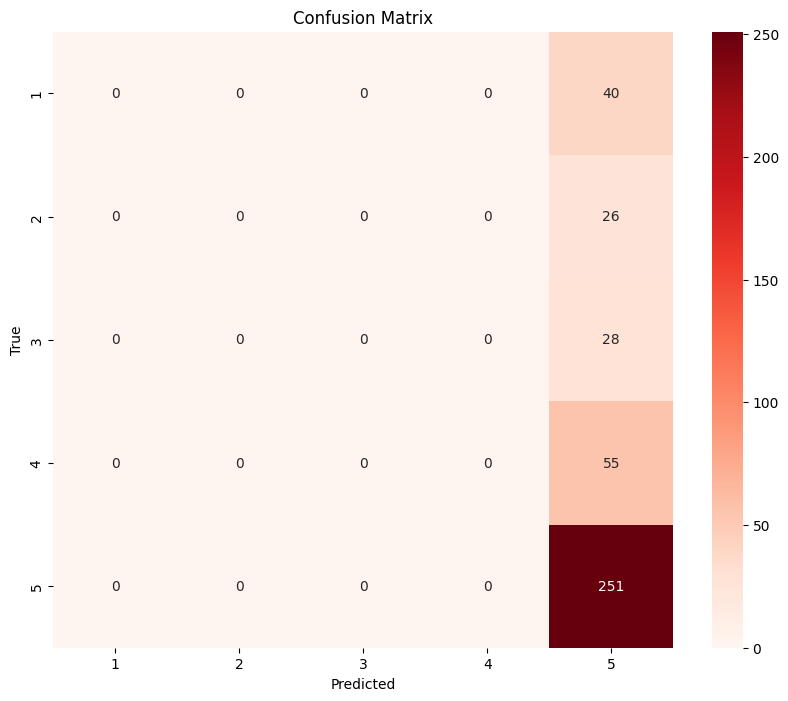

Accuracy: 0.6275
              precision    recall  f1-score   support

           1       1.00      0.00      0.00        40
           2       1.00      0.00      0.00        26
           3       1.00      0.00      0.00        28
           4       1.00      0.00      0.00        55
           5       0.63      1.00      0.77       251

    accuracy                           0.63       400
   macro avg       0.93      0.20      0.15       400
weighted avg       0.77      0.63      0.48       400



In [ ]:
#Review/Score Classifier using Naive Bayes

# Features
features_text = processed_df['combined_text']
features_vader_compound_score = processed_df['updated_compound_score'].values.reshape(-1, 1)
features_vader_encoded = processed_df['vader_sentiment_encoded'].values.reshape(-1,1)

# Text Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000000)
X_tfidf = tfidf_vectorizer.fit_transform(features_text)

# Combined Features

X_combined = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_combined['vader_compound_score'] = features_vader_compound_score
X_combined['vader_sentiment_encoded'] = features_vader_encoded

# Data Split for Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_combined, processed_df['review/score'], test_size=0.2, random_state=42)

# Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Prediction
y_pred = nb_classifier.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=nb_classifier.classes_, yticklabels=nb_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy Check
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred, zero_division=1))


I used a naive bayes model as mentioned for the assignment. I had several issues using the model. First, I attempted to use spacy's word vectorizer function, but this produced continuous values/or negative values which were not compatible with the model. I found tfid vectorizer which does not have the same problems and chose to use it. Next, my sentiment values were not able to used with the model so I used a label encoder to assign a numerical value to postive, negative, and neutral (as mentioned above). Finally, I had issues with negative values in vader_compound_score and added a 1 to each value to be used in the model. I reshaped columns to be used together and I arrived at an accuracy of 62.75%.

I did not achieve any meaningful benefit from using other columns such as userID or review time and omitted them from the model. I wanted to include the text of the reviews in my analysis because that was point of the assignment. I used TFID vectorizer because it worked in the model, but also because TFID weighs the importance of words based on their frequency and belived that it may provide some benefit to the model. I added my sentiment labels, as well as vader_compound_score, because I believe it could provide some value to the model beyond what TFID vectorizer could do alone.



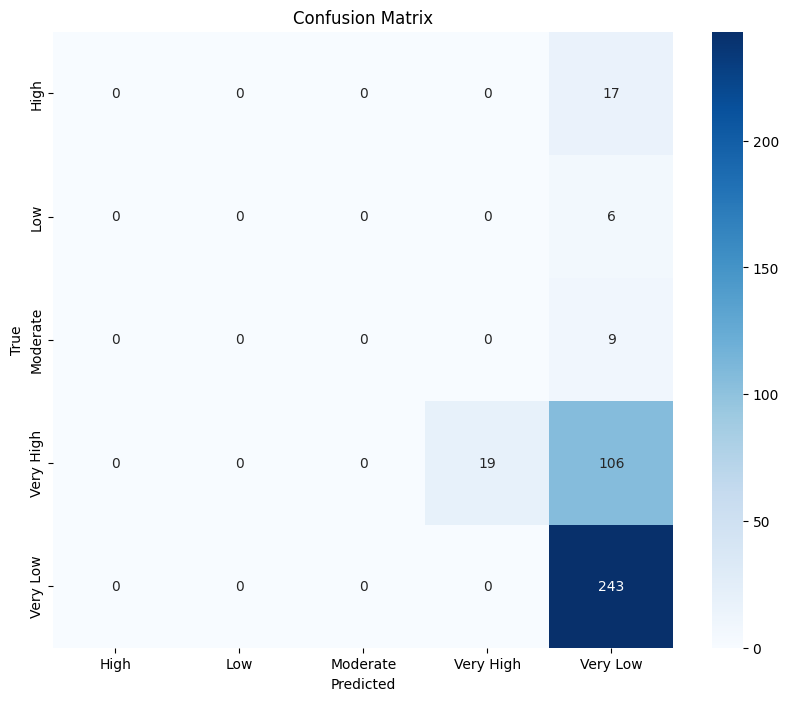

Accuracy: 0.655
              precision    recall  f1-score   support

        High       1.00      0.00      0.00        17
         Low       1.00      0.00      0.00         6
    Moderate       1.00      0.00      0.00         9
   Very High       1.00      0.15      0.26       125
    Very Low       0.64      1.00      0.78       243

    accuracy                           0.66       400
   macro avg       0.93      0.23      0.21       400
weighted avg       0.78      0.66      0.56       400



In [ ]:
# Review/Helpfulness Predictor using Naive Bayes

# Convert timestamp
processed_df['review_time'] = pd.to_datetime(processed_df['review/time'], unit='s')

# Extract Time Data
processed_df['year'] = processed_df['review_time'].dt.year
processed_df['month'] = processed_df['review_time'].dt.month
processed_df['day'] = processed_df['review_time'].dt.day
processed_df['hour'] = processed_df['review_time'].dt.hour

# Calculate age of review
earliest_review_time = processed_df['review_time'].min()
processed_df['days_since_earliest'] = (processed_df['review_time'] - earliest_review_time).dt.days

# Convert Review/Helpfulness to Float Value
def convert_to_ratio(x):
    if '/' in x:
        numerator, denominator = map(int, x.split('/'))
        return numerator / denominator if denominator != 0 else 0
    else:
        return float(x)

processed_df['helpfulness_ratio'] = processed_df['review/helpfulness'].apply(convert_to_ratio)

# Features
features_text = processed_df['combined_text']
features_vader_compound_score = processed_df['updated_compound_score'].values.reshape(-1, 1)
features_vader_encoded = processed_df['vader_sentiment_encoded'].values.reshape(-1, 1)
features_review_score = processed_df['review/score'].values.reshape(-1, 1)
features_days_since_earliest = processed_df['days_since_earliest'].values.reshape(-1, 1)
features_helpfulness_ratio = processed_df['helpfulness_ratio'].values.reshape(-1, 1)

# Text Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000000)
X_tfidf = tfidf_vectorizer.fit_transform(features_text)

# Combined Features
X_combined = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
X_combined['vader_compound_score'] = features_vader_compound_score
X_combined['vader_sentiment_encoded'] = features_vader_encoded
X_combined['review/score'] = features_review_score
X_combined['days_since_earliest'] = features_days_since_earliest
X_combined['helpfulness_ratio'] = features_helpfulness_ratio

# Convert 'helpfulness_ratio' into categories for classification (adjust as needed)
processed_df['helpfulness_category'] = pd.cut(processed_df['helpfulness_ratio'], bins=[-float('inf'), 0.2, 0.4, 0.6, 0.8, 1.0], labels=['Very Low', 'Low', 'Moderate', 'High', 'Very High'])

# Data Split for Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_combined, processed_df['helpfulness_category'], test_size=0.2, random_state=42)

# Naive Bayes
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# Prediction
y_pred = nb_classifier.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=nb_classifier.classes_, yticklabels=nb_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy Check
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred, zero_division=1))


I attempted to predict the review/helpfulness using naive bayes. I incorporated all of my previous features, but added review/score this time. Because review/helpfulness is dependent on the time of the review, I converted review/time into a date time format. I extracted the relevant components and created a new column days_since_earliest with a function that determines the age of the review in relation to the first review. I did this in an attempt to factor time into predicting review/helpfulness. Next, I converted the review/helpfulness into a numerical value to be used. This value is then assigned a label of very low, low, moderate, high, very high to be used for predictions. Finally, I ran the model and obtained an accuracy of 65.5%.